In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [70]:
# Source Data from Kaggle
# https://www.kaggle.com/muhammetvarl/laptop-price
df = pd.read_csv('laptop_price.csv')
df.shape

(1303, 13)

In [71]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [72]:
df.head()

laptop_ID Company      Product   TypeName  Inches  \
0          1   Apple  MacBook Pro  Ultrabook   13.30   
1          2   Apple  Macbook Air  Ultrabook   13.30   
2          3      HP       250 G6   Notebook   15.60   
3          4   Apple  MacBook Pro  Ultrabook   15.40   
4          5   Apple  MacBook Pro  Ultrabook   13.30   

                     ScreenResolution                         Cpu   Ram  \
0  IPS Panel Retina Display 2560x1600        Intel Core i5 2.3GHz   8GB   
1                            1440x900        Intel Core i5 1.8GHz   8GB   
2                   Full HD 1920x1080  Intel Core i5 7200U 2.5GHz   8GB   
3  IPS Panel Retina Display 2880x1800        Intel Core i7 2.7GHz  16GB   
4  IPS Panel Retina Display 2560x1600        Intel Core i5 3.1GHz   8GB   

                Memory                           Gpu  OpSys  Weight  \
0            128GB SSD  Intel Iris Plus Graphics 640  macOS  1.37kg   
1  128GB Flash Storage        Intel HD Graphics 6000  macOS  1.34kg   
2            256GB SSD         Intel HD Graphics 620  No OS  1.86kg   
3            512GB SSD            AMD Radeon Pro 455  macOS  1.83kg   
4            256GB SSD  Intel Iris Plus Graphics 650  macOS  1.37kg   

   Price_euros  
0      1339.69  
1       898.94  
2       575.00  
3      2537.45  
4      1803.60

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


## Q: Can we predict a price based on features? (Regression Model)

### First clean the data, and then do TTS to split for model training and scoring

#### Data Wrangling

In [74]:
# laptop ID is not very useful for our analysis
df = df.drop(columns = 'laptop_ID')

In [75]:
# Create Dummy value for EDA
df['dummy'] = 1

Fix some data type if possible
- Change Ram and Weight to numeric

In [76]:
df['Ram'] = df['Ram'].str.replace('GB', '').astype(float)
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

- Split CPU into clock speed and model

In [77]:
def splitClock(name):
    rx = '(.*) ([0-9.]*GHz)'
    x = re.findall(rx, name)
    return x
df['x'] = df['Cpu'].apply(lambda x: splitClock(x))
df['Cpu_name'] = df['x'].apply(lambda x: x[0][0])
df['Cpu_clockspeed'] = df['x'].apply(lambda x: x[0][1])
df['Cpu_clockspeed'] = df['Cpu_clockspeed'].str.replace('GHz', '').astype(float)
df = df.drop(columns=['x', 'Cpu'])
df.head()

Company      Product   TypeName  Inches                    ScreenResolution  \
0   Apple  MacBook Pro  Ultrabook   13.30  IPS Panel Retina Display 2560x1600   
1   Apple  Macbook Air  Ultrabook   13.30                            1440x900   
2      HP       250 G6   Notebook   15.60                   Full HD 1920x1080   
3   Apple  MacBook Pro  Ultrabook   15.40  IPS Panel Retina Display 2880x1800   
4   Apple  MacBook Pro  Ultrabook   13.30  IPS Panel Retina Display 2560x1600   

    Ram               Memory                           Gpu  OpSys  Weight  \
0  8.00            128GB SSD  Intel Iris Plus Graphics 640  macOS    1.37   
1  8.00  128GB Flash Storage        Intel HD Graphics 6000  macOS    1.34   
2  8.00            256GB SSD         Intel HD Graphics 620  No OS    1.86   
3 16.00            512GB SSD            AMD Radeon Pro 455  macOS    1.83   
4  8.00            256GB SSD  Intel Iris Plus Graphics 650  macOS    1.37   

   Price_euros  dummy             Cpu_name  Cpu_clockspeed  
0      1339.69      1        Intel Core i5            2.30  
1       898.94      1        Intel Core i5            1.80  
2       575.00      1  Intel Core i5 7200U            2.50  
3      2537.45      1        Intel Core i7            2.70  
4      1803.60      1        Intel Core i5            3.10

- Split display type into display type and resolution

In [78]:
def splitRes(name):
    rx = '(.*) ([0-9x]*)'
    x = re.findall(rx, name)
    # Some Screen Res got no name, only res. Return (0,0) as placeholder and then fix later
    if len(x) == 0:
        return [(0,0)]
    return x
df['x'] = df['ScreenResolution'].apply(lambda x: splitRes(x))
df['ScreenType'] = df['x'].apply(lambda x: x[0][0])
df['ScreenRes'] = df['x'].apply(lambda x: x[0][1])
df['ScreenType'] = np.where(df['ScreenType'] == 0, 'Not Available', df['ScreenType'])
df['ScreenRes'] = np.where(df['ScreenRes'] == 0, df['ScreenResolution'], df['ScreenRes'])

def widthHeight(name):
    rx = '([0-9]*)x([0-9]*)'
    x = re.findall(rx, name)
    return x

df['x'] = df['ScreenRes'].apply(widthHeight)
df['Width'] = df['x'] .apply(lambda x: x[0][0]).astype(int)
df['Height'] = df['x'] .apply(lambda x: x[0][1]).astype(int)
df = df.drop(columns=['x', 'ScreenRes', 'ScreenResolution'])
df.head()

Company      Product   TypeName  Inches   Ram               Memory  \
0   Apple  MacBook Pro  Ultrabook   13.30  8.00            128GB SSD   
1   Apple  Macbook Air  Ultrabook   13.30  8.00  128GB Flash Storage   
2      HP       250 G6   Notebook   15.60  8.00            256GB SSD   
3   Apple  MacBook Pro  Ultrabook   15.40 16.00            512GB SSD   
4   Apple  MacBook Pro  Ultrabook   13.30  8.00            256GB SSD   

                            Gpu  OpSys  Weight  Price_euros  dummy  \
0  Intel Iris Plus Graphics 640  macOS    1.37      1339.69      1   
1        Intel HD Graphics 6000  macOS    1.34       898.94      1   
2         Intel HD Graphics 620  No OS    1.86       575.00      1   
3            AMD Radeon Pro 455  macOS    1.83      2537.45      1   
4  Intel Iris Plus Graphics 650  macOS    1.37      1803.60      1   

              Cpu_name  Cpu_clockspeed                ScreenType  Width  \
0        Intel Core i5            2.30  IPS Panel Retina Display   2560   
1        Intel Core i5            1.80             Not Available   1440   
2  Intel Core i5 7200U            2.50                   Full HD   1920   
3        Intel Core i7            2.70  IPS Panel Retina Display   2880   
4        Intel Core i5            3.10  IPS Panel Retina Display   2560   

   Height  
0    1600  
1     900  
2    1080  
3    1800  
4    1600

- Split GPU Brand

In [79]:
def splitGpu(name):
    rx = '(^[a-zA-Z]*) (.*)'
    x = re.findall(rx, name)
    return x
df['x'] = df['Gpu'].apply(lambda x: splitGpu(x))
df['GPU_brand'] = df['x'].apply(lambda x: x[0][0])
df['GPU_model'] = df['x'].apply(lambda x: x[0][1])
df = df.drop(columns=['x', 'Gpu'])
df.head()

Company      Product   TypeName  Inches   Ram               Memory  OpSys  \
0   Apple  MacBook Pro  Ultrabook   13.30  8.00            128GB SSD  macOS   
1   Apple  Macbook Air  Ultrabook   13.30  8.00  128GB Flash Storage  macOS   
2      HP       250 G6   Notebook   15.60  8.00            256GB SSD  No OS   
3   Apple  MacBook Pro  Ultrabook   15.40 16.00            512GB SSD  macOS   
4   Apple  MacBook Pro  Ultrabook   13.30  8.00            256GB SSD  macOS   

   Weight  Price_euros  dummy             Cpu_name  Cpu_clockspeed  \
0    1.37      1339.69      1        Intel Core i5            2.30   
1    1.34       898.94      1        Intel Core i5            1.80   
2    1.86       575.00      1  Intel Core i5 7200U            2.50   
3    1.83      2537.45      1        Intel Core i7            2.70   
4    1.37      1803.60      1        Intel Core i5            3.10   

                 ScreenType  Width  Height GPU_brand               GPU_model  
0  IPS Panel Retina Display   2560    1600     Intel  Iris Plus Graphics 640  
1             Not Available   1440     900     Intel        HD Graphics 6000  
2                   Full HD   1920    1080     Intel         HD Graphics 620  
3  IPS Panel Retina Display   2880    1800       AMD          Radeon Pro 455  
4  IPS Panel Retina Display   2560    1600     Intel  Iris Plus Graphics 650

- Change storage into TB and type (there are laptops with 2 drives, need to break it into 4 columns)

In [80]:
def splitStorage(name):
    rx = '(.*)\+(.*)'
    x = re.findall(rx, name)
    if len(x) == 0:
        return [(0,0)]
    return x
df['x'] = df['Memory'].apply(splitStorage)

df['drive1'] = df['x'].apply(lambda x: str(x[0][0]).strip())
df['drive2'] = df['x'].apply(lambda x: str(x[0][1]).strip())
df['drive1'] = np.where(df['drive1'] == '0', df['Memory'], df['drive1'])

def splitDriveType(name):
    rx = '([0-9A-Z]*) ([A-Za-z ].*)'
    x = re.findall(rx, name)
    if len(x) == 0:
        return [('0TB','None')]
    return x
df['x'] = df['drive1'].apply(splitDriveType)
df['drive1_storage'] = df['x'].apply(lambda x: str(x[0][0]).strip())
df['drive1_tb'] = np.where(df['drive1_storage'].str[-2:] == 'GB', (df['drive1_storage'].str[:-2].astype(float))/1024, df['drive1_storage'].str[:-2].astype(float))
df['drive1_type'] = df['x'].apply(lambda x: str(x[0][1]).strip())

df['x'] = df['drive2'].apply(splitDriveType)
df['drive2_storage'] = df['x'].apply(lambda x: str(x[0][0]).strip())
df['drive2_tb'] = np.where(df['drive2_storage'].str[-2:] == 'GB', (df['drive2_storage'].str[:-2].astype(float))/1024, df['drive2_storage'].str[:-2].astype(float))
df['drive2_type'] = df['x'].apply(lambda x: str(x[0][1]).strip())

df = df.drop(columns = ['x', 'drive1', 'drive2', 'drive1_storage', 'drive2_storage', 'Memory'])

In [81]:
df.head(50)

Company                                    Product            TypeName  \
0    Apple                                MacBook Pro           Ultrabook   
1    Apple                                Macbook Air           Ultrabook   
2       HP                                     250 G6            Notebook   
3    Apple                                MacBook Pro           Ultrabook   
4    Apple                                MacBook Pro           Ultrabook   
5     Acer                                   Aspire 3            Notebook   
6    Apple                                MacBook Pro           Ultrabook   
7    Apple                                Macbook Air           Ultrabook   
8     Asus                            ZenBook UX430UN           Ultrabook   
9     Acer                                    Swift 3           Ultrabook   
10      HP                                     250 G6            Notebook   
11      HP                                     250 G6            Notebook   
12   Apple                                MacBook Pro           Ultrabook   
13    Dell                              Inspiron 3567            Notebook   
14   Apple                                MacBook 12"           Ultrabook   
15   Apple                                MacBook Pro           Ultrabook   
16    Dell                              Inspiron 3567            Notebook   
17   Apple                                MacBook Pro           Ultrabook   
18  Lenovo                          IdeaPad 320-15IKB            Notebook   
19    Dell                                     XPS 13           Ultrabook   
20    Asus                            Vivobook E200HA             Netbook   
21  Lenovo                         Legion Y520-15IKBN              Gaming   
22      HP                                     255 G6            Notebook   
23    Dell                              Inspiron 5379  2 in 1 Convertible   
24      HP    15-BS101nv (i7-8550U/8GB/256GB/FHD/W10)           Ultrabook   
25    Dell                              Inspiron 3567            Notebook   
26   Apple                                MacBook Air           Ultrabook   
27    Dell                              Inspiron 5570            Notebook   
28    Dell                              Latitude 5590           Ultrabook   
29      HP                                ProBook 470            Notebook   
30   Chuwi                              LapBook 15.6"            Notebook   
31    Asus       E402WA-GA010T (E2-6110/2GB/32GB/W10)            Notebook   
32      HP       17-ak001nv (A6-9220/4GB/500GB/Radeon            Notebook   
33    Dell                                     XPS 13           Ultrabook   
34   Apple                                MacBook Air           Ultrabook   
35  Lenovo                         IdeaPad 120S-14IAP            Notebook   
36    Acer                                   Aspire 3            Notebook   
37    Dell                              Inspiron 5770            Notebook   
38      HP                                     250 G6            Notebook   
39      HP                                ProBook 450            Notebook   
40    Asus  X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux)            Notebook   
41    Dell                              Inspiron 7577              Gaming   
42    Asus     X542UQ-GO005 (i5-7200U/8GB/1TB/GeForce            Notebook   
43    Acer                            Aspire A515-51G            Notebook   
44    Dell                              Inspiron 7773  2 in 1 Convertible   
45   Apple                                MacBook Pro           Ultrabook   
46  Lenovo                          IdeaPad 320-15ISK            Notebook   
47    Asus                                  Rog Strix              Gaming   
48    Dell                              Inspiron 3567            Notebook   
49    Asus       X751NV-TY001T (N4200/4GB/1TB/GeForce            Notebook   

    Inches   Ram       OpSys  Weight  Price_euros  dummy  \
0    13.30  8.0

### EDA

In [82]:
df.describe()

Inches     Ram  Weight  Price_euros   dummy  Cpu_clockspeed   Width  \
count 1303.00 1303.00 1303.00      1303.00 1303.00         1303.00 1303.00   
mean    15.02    8.38    2.04      1123.69    1.00            2.30 1894.78   
std      1.43    5.08    0.67       699.01    0.00            0.51  494.64   
min     10.10    2.00    0.69       174.00    1.00            0.90 1366.00   
25%     14.00    4.00    1.50       599.00    1.00            2.00 1600.00   
50%     15.60    8.00    2.04       977.00    1.00            2.50 1920.00   
75%     15.60    8.00    2.30      1487.88    1.00            2.70 1920.00   
max     18.40   64.00    4.70      6099.00    1.00            3.60 3840.00   

       Height  drive1_tb  drive2_tb  
count 1303.00    1303.00    1303.00  
mean  1070.83       0.43       0.17  
std    284.52       0.36       0.40  
min    768.00       0.00       0.00  
25%    900.00       0.25       0.00  
50%   1080.00       0.25       0.00  
75%   1080.00       0.50       0.00  
max   2160.00       2.00       2.00

#### General consensus - Apple product is most expensive but it doesn't seems like it when we are looking at average/median laptop price

##### Mean

<AxesSubplot:xlabel='Company', ylabel='Price_euros'>

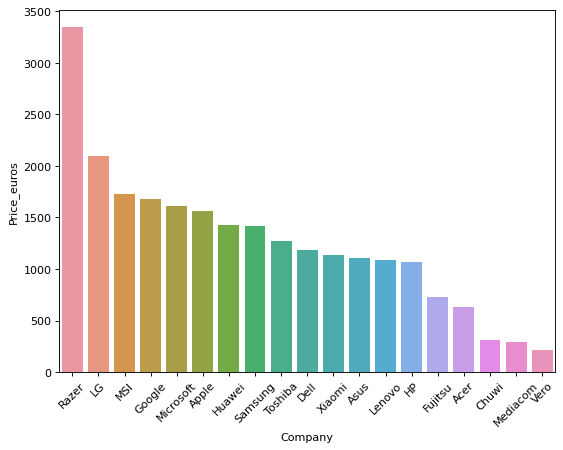

In [83]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

company_price = df.groupby('Company').mean().reset_index().sort_values('Price_euros', ascending = False)
sns.barplot(data = company_price, x = 'Company', y = 'Price_euros')

##### Median

<AxesSubplot:xlabel='Company', ylabel='Price_euros'>

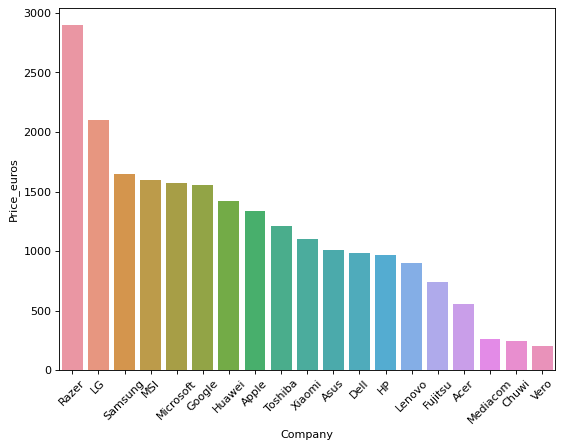

In [84]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

company_price = df.groupby('Company').median().reset_index().sort_values('Price_euros', ascending = False)
sns.barplot(data = company_price, x = 'Company', y = 'Price_euros')

#### Generally workstation and gaming laptops are more expensive than the rest.

<AxesSubplot:xlabel='TypeName', ylabel='Price_euros'>

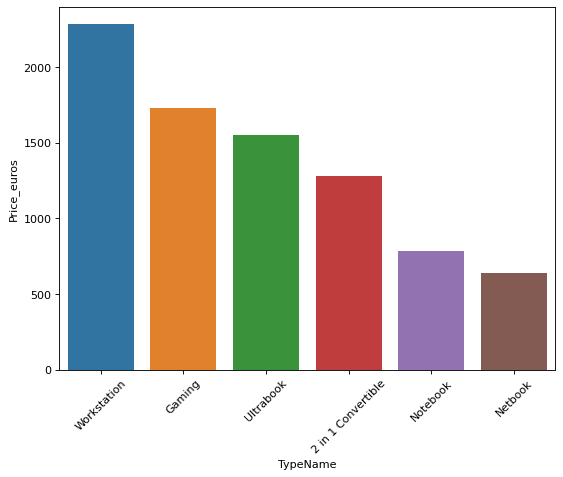

In [85]:
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

type_price = df.groupby('TypeName').mean().reset_index().sort_values('Price_euros', ascending = False)
sns.barplot(data = type_price, x = 'TypeName', y = 'Price_euros')


#### Larger Screen Size doesn't necessarily means it's more expensive

<AxesSubplot:xlabel='Inches', ylabel='Price_euros'>

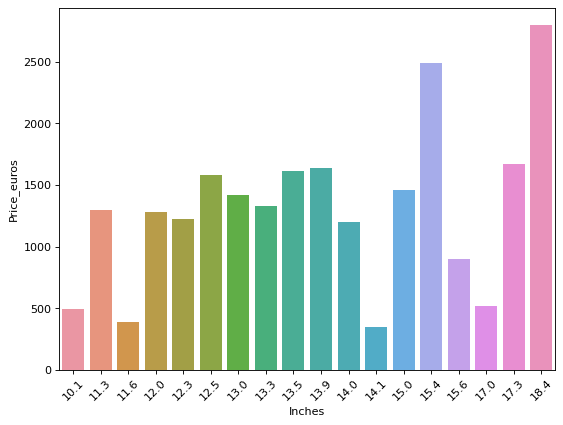

In [86]:
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

size_price = df.groupby('Inches').mean().reset_index().sort_values(by = 'Inches', ascending = False)
sns.barplot(data = size_price, x = 'Inches', y = 'Price_euros')


#### Most product line are Notebook.

<AxesSubplot:xlabel='TypeName', ylabel='dummy'>

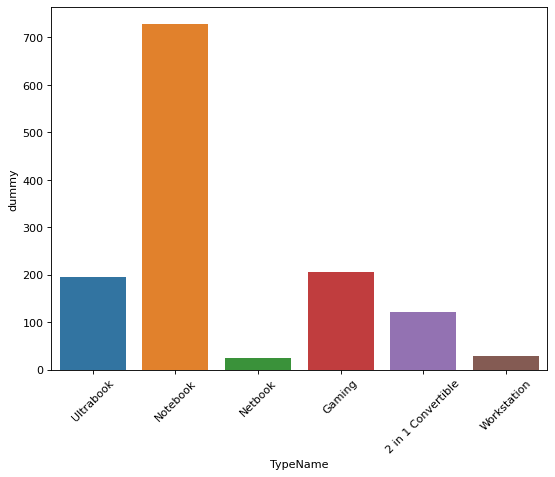

In [87]:
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

sns.barplot(data = df, x='TypeName', y = 'dummy', estimator=sum)

#### Does GPU Brand affect the price range?
- Nvidia gpu laptop tends to be more expensive

<AxesSubplot:xlabel='GPU_brand', ylabel='Price_euros'>

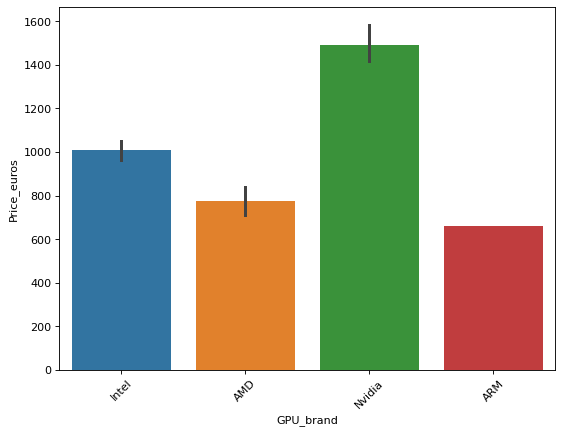

In [88]:
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

sns.barplot(data = df, x='GPU_brand', y = 'Price_euros', estimator=np.mean)

#### Most of the notebooks are from 0-16GB RAM and gaming laptop are from 16-32GB+ RAM range.

<AxesSubplot:xlabel='Price_euros', ylabel='Ram'>

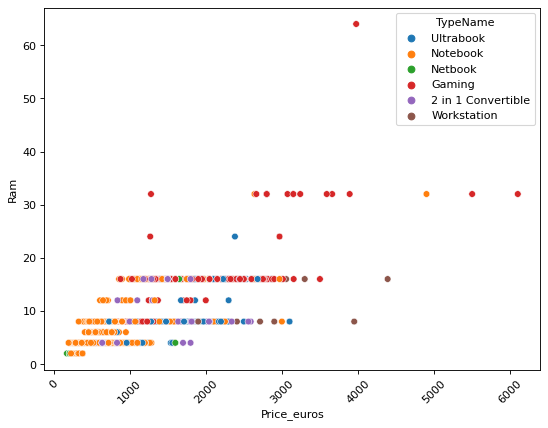

In [89]:
figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)

sns.scatterplot(x=df['Price_euros'], y=df['Ram'], hue=df['TypeName'])

In [90]:
# Is this correct?
# Vallidate with their mean and median
df[['TypeName', 'Ram']].groupby('TypeName').mean().sort_values('Ram', ascending=False)

Ram
TypeName                
Gaming             14.05
Workstation        10.48
Ultrabook           9.44
2 in 1 Convertible  8.66
Notebook            6.50
Netbook             4.64

In [91]:
df[['TypeName', 'Ram']].groupby('TypeName').median().sort_values('Ram', ascending=False)

Ram
TypeName                
Gaming             16.00
2 in 1 Convertible  8.00
Ultrabook           8.00
Workstation         8.00
Notebook            6.00
Netbook             4.00

#### Width and Height are 1:1 correlation because usually the screen size commercially sold are fairly standard.
#### Seems like higher ram have a very high correlation with higher price.
#### Weight and inches have a high correlation and this makes perfectly sense. A thicker laptop is most likely heavier.
#### However, weight actually doesn't correlate with the screen size as much as you'd think. A larger screen doesn't necessarily means it's more heavy.

<AxesSubplot:>

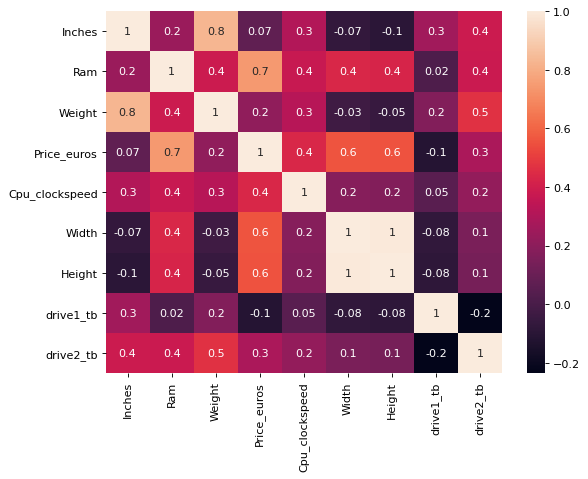

In [92]:
figure(figsize=(8, 6), dpi=80)
sns.heatmap(df.drop(columns = 'dummy').corr(), annot = True, fmt='.1g')

In [93]:
# Drop dummy value after EDA
# For prediction, shouldn't use product name as feature 
df = df.drop(columns = ['dummy', 'Product'])
df 

Company            TypeName  Inches   Ram         OpSys  Weight  \
0         Apple           Ultrabook   13.30  8.00         macOS    1.37   
1         Apple           Ultrabook   13.30  8.00         macOS    1.34   
2            HP            Notebook   15.60  8.00         No OS    1.86   
3         Apple           Ultrabook   15.40 16.00         macOS    1.83   
4         Apple           Ultrabook   13.30  8.00         macOS    1.37   
5          Acer            Notebook   15.60  4.00    Windows 10    2.10   
6         Apple           Ultrabook   15.40 16.00      Mac OS X    2.04   
7         Apple           Ultrabook   13.30  8.00         macOS    1.34   
8          Asus           Ultrabook   14.00 16.00    Windows 10    1.30   
9          Acer           Ultrabook   14.00  8.00    Windows 10    1.60   
10           HP            Notebook   15.60  4.00         No OS    1.86   
11           HP            Notebook   15.60  4.00         No OS    1.86   
12        Apple           Ultrabook   15.40 16.00         macOS    1.83   
13         Dell            Notebook   15.60  4.00    Windows 10    2.20   
14        Apple           Ultrabook   12.00  8.00         macOS    0.92   
15        Apple           Ultrabook   13.30  8.00         macOS    1.37   
16         Dell            Notebook   15.60  8.00    Windows 10    2.20   
17        Apple           Ultrabook   15.40 16.00         macOS    1.83   
18       Lenovo            Notebook   15.60  8.00         No OS    2.20   
19         Dell           Ultrabook   13.30  8.00    Windows 10    1.22   
20         Asus             Netbook   11.60  2.00    Windows 10    0.98   
21       Lenovo              Gaming   15.60  8.00    Windows 10    2.50   
22           HP            Notebook   15.60  4.00         No OS    1.86   
23         Dell  2 in 1 Convertible   13.30  8.00    Windows 10    1.62   
24           HP           Ultrabook   15.60  8.00    Windows 10    1.91   
25         Dell            Notebook   15.60  4.00    Windows 10    2.30   
26        Apple           Ultrabook   13.30  8.00      Mac OS X    1.35   
27         Dell            Notebook   15.60  8.00    Windows 10    2.20   
28         Dell           Ultrabook   15.60  8.00    Windows 10    1.88   
29           HP            Notebook   17.30  8.00    Windows 10    2.50   
30        Chuwi            Notebook   15.60  4.00    Windows 10    1.89   
31         Asus            Notebook   14.00  2.00    Windows 10    1.65   
32           HP            Notebook   17.30  4.00    Windows 10    2.71   
33         Dell           Ultrabook   13.30 16.00    Windows 10    1.20   
34        Apple           Ultrabook   13.30  8.00      Mac OS X    1.35   
35       Lenovo            Notebook   14.00  4.00    Windows 10    1.44   
36         Acer            Notebook   15.60  4.00         Linux    2.10   
37         Dell            Notebook   17.30  8.00    Windows 10    2.80   
38           HP            Notebook   15.60  4.00    Windows 10    1.86   
39           HP            Notebook   15.60  8.00    Windows 10    2.10   
40         Asus            Notebook   15.60  4.00         Linux    2.00   
41         Dell              Gaming   15.60 16.00    Windows 10    2.65   
42         Asus            Notebook   15.60  8.00         Linux    2.30   
43         Acer            Notebook   15.60  4.00    Windows 10    2.20   
44         Dell  2 in 1 Convertible   17.30 12.00    Windows 10    2.77   
45        Apple           Ultrabook   13.30  8.00         macOS    1.37   
46       Lenovo            Notebook   15.60  4.00         No OS    2.20   
47         Asus              Gaming   17.30  8.00    Windows 10    3.20   
48         Dell            Notebook   15.60  4.00    Windows 10    2.30   
49         Asus            Notebook   17.30  4.00    Windows 10    2.80   
50       Lenovo  2 in 1 Convertible   10.10  4.00       Android    0.69   
51         Acer            Notebook   15.60  8.00    Windows 10    2.20   
52           HP            Notebo

## Modelling Time

In [94]:
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

##### Need to encode categorical columns into One Hot Encoding

In [95]:
df = pd.concat([df, pd.get_dummies(df['Company'])], axis = 1).drop(columns = 'Company')
df = pd.concat([df, pd.get_dummies(df['TypeName'])], axis = 1).drop(columns = 'TypeName')
df = pd.concat([df, pd.get_dummies(df['OpSys'])], axis = 1).drop(columns = 'OpSys')
df = pd.concat([df, pd.get_dummies(df['Cpu_name'])], axis = 1).drop(columns = 'Cpu_name')
df = pd.concat([df, pd.get_dummies(df['ScreenType'])], axis = 1).drop(columns = 'ScreenType')
df = pd.concat([df, pd.get_dummies(df['GPU_brand'])], axis = 1).drop(columns = 'GPU_brand')
df = pd.concat([df, pd.get_dummies(df['GPU_model'])], axis = 1).drop(columns = 'GPU_model')
df = pd.concat([df, pd.get_dummies(df['drive1_type'], prefix='drive1')], axis = 1).drop(columns = 'drive1_type')
df = pd.concat([df, pd.get_dummies(df['drive2_type'], prefix='drive2')], axis = 1).drop(columns = 'drive2_type')

In [96]:
df.shape # 278 features, 1 label

(1303, 279)

In [97]:
df.head()

Inches   Ram  Weight  Price_euros  Cpu_clockspeed  Width  Height  \
0   13.30  8.00    1.37      1339.69            2.30   2560    1600   
1   13.30  8.00    1.34       898.94            1.80   1440     900   
2   15.60  8.00    1.86       575.00            2.50   1920    1080   
3   15.40 16.00    1.83      2537.45            2.70   2880    1800   
4   13.30  8.00    1.37      1803.60            3.10   2560    1600   

   drive1_tb  drive2_tb  Acer  Apple  Asus  Chuwi  Dell  Fujitsu  Google  HP  \
0       0.12       0.00     0      1     0      0     0        0       0   0   
1       0.12       0.00     0      1     0      0     0        0       0   0   
2       0.25       0.00     0      0     0      0     0        0       0   1   
3       0.50       0.00     0      1     0      0     0        0       0   0   
4       0.25       0.00     0      1     0      0     0        0       0   0   

   Huawei  LG  Lenovo  MSI  Mediacom  Microsoft  Razer  Samsung  Toshiba  \
0       0   0       0    0         0          0      0        0        0   
1       0   0       0    0         0          0      0        0        0   
2       0   0       0    0         0          0      0        0        0   
3       0   0       0    0         0          0      0        0        0   
4       0   0       0    0         0          0      0        0        0   

   Vero  Xiaomi  2 in 1 Convertible  Gaming  Netbook  Notebook  Ultrabook  \
0     0       0                   0       0        0         0          1   
1     0       0                   0       0        0         0          1   
2     0       0                   0       0        0         1          0   
3     0       0                   0       0        0         0          1   
4     0       0                   0       0        0         0          1   

   Workstation  Android  Chrome OS  Linux  Mac OS X  No OS  Windows 10  \
0            0        0          0      0         0      0           0   
1            0        0          0      0         0      0           0   
2            0        0          0      0         0      1           0   
3            0        0          0      0         0      0           0   
4            0        0          0      0         0      0           0   

   Windows 10 S  Windows 7  macOS  AMD A10-Series 9600P  AMD A10-Series 9620P  \
0             0          0      1                     0                     0   
1             0          0      1                     0                     0   
2             0          0      0                     0                     0   
3             0          0      1                     0                     0   
4             0          0      1                     0                     0   

   AMD A10-Series A10-9620P  AMD A12-Series 9700P  AMD A12-Series 9720P  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   

   AMD A4-Series 7210  AMD A6-Series 7310  AMD A6-Series 9220  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   AMD A6-Series A6-9220  AMD A8-Series 7410  AMD A9-Series 9410  \
0                      0                   0                   0   
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                 

### Split feature and label

In [98]:
# Predict Laptop Price
df_X = df.drop(columns = 'Price_euros')
df_y = df[['Price_euros']]

### Feature Selection

In [99]:
# Decision Tree feature importance takes very long to run

In [100]:
import sklearn.model_selection
grid = sklearn.model_selection.GridSearchCV(
    DecisionTreeRegressor(random_state=1),
    param_grid={'max_depth': range(1,10)},
    cv=sklearn.model_selection.LeaveOneOut(),
    scoring='neg_root_mean_squared_error'
)
grid.fit(df_X, df_y)

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': range(1, 10)},
             scoring='neg_root_mean_squared_error')

In [101]:
feature_cols = df_X.columns

In [102]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature.
# Ram plays the biggest role in term of price
# However in real life scenario, RAM are upgradeable and it doesn't actually cost that much.
pd.DataFrame({'feature':feature_cols, 'importance':grid.best_estimator_.feature_importances_}).sort_values(by='importance', ascending = False)

feature  importance
1                                    Ram        0.64
2                                 Weight        0.06
30                              Notebook        0.05
3                         Cpu_clockspeed        0.04
22                                 Razer        0.03
0                                 Inches        0.02
32                           Workstation        0.02
4                                  Width        0.02
273                           drive1_SSD        0.02
182                     GeForce GTX 1070        0.01
132               Intel Xeon E3-1535M v5        0.01
277                           drive2_SSD        0.01
230                        Quadro M3000M        0.01
6                              drive1_tb        0.01
5                                 Height        0.01
136            4K Ultra HD / Touchscreen        0.00
192                     GeForce GTX 965M        0.00
10                                  Asus        0.00
145     IPS Panel Quad HD+ / Touchscreen        0.00
15                                    HP        0.00
191                     GeForce GTX 960M        0.00
7                              drive2_tb        0.00
106                  Intel Core i5 8250U        0.00
40                             Windows 7        0.00
12                                  Dell        0.00
276                          drive2_None        0.00
209                      HD Graphics 520        0.00
91                   Intel Core i3 7100U        0.00
163                       FirePro W6150M        0.00
158                                Intel        0.00
8                                   Acer        0.00
159                               Nvidia        0.00
27                    2 in 1 Convertible        0.00
135                          4K Ultra HD        0.00
53                    AMD A9-Series 9420        0.00
79                          Intel Core M        0.00
183                    GeForce GTX 1070M        0.00
215                      HD Graphics 620        0.00
49                    AMD A6-Series 9220        0.00
36                              Mac OS X        0.00
108                  Intel Core i7 6500U        0.00
174                        GeForce 940MX        0.00
161                      FirePro W4190M         0.00
142                    IPS Panel Full HD        0.00
37                                 No OS        0.00
90                   Intel Core i3 6100U        0.00
97                   Intel Core i5 6300U        0.00
99                   Intel Core i5 7200U        0.00
269                     UHD Graphics 620        0.00
75         Intel Celeron Dual Core N3350        0.00
35                                 Linux        0.00
101                  Intel Core i5 7300U        0.00
94                   Intel Core i5 6200U        0.00
171                        GeForce 930MX        0.00
152                          Touchscreen        0.00
138                Full HD / Touchscreen        0.00
38                            Windows 10        0.00
89                   Intel Core i3 6006U        0.00
120                 Intel Core i7 7820HK        0.00
274                           drive2_HDD        0.00
271                           drive1_HDD        0.00
111                 Intel Core i7 6700HQ        0.00
137                              Full HD        0.00
19                                   MSI        0.00
98                  Intel Core i5 6440HQ        0.00
218                    Iris Graphics 540        0.00
188                     GeForce GTX 950M        0.00
205                      HD Graphics 500        0.00
119                 Intel Core i7 7700HQ        0.00
149                        Not Available        0.00
177                     GeForce GTX 1050        0.00
18                                Lenovo        0.00
140                IPS Panel 4K Ultra HD        0.00
31                             Ultrabook        0.00
204                      HD Graphics 405        0.00
172  

In [103]:
# Look at the correlation
corr_matrix = df_X.corr().abs()

<AxesSubplot:>

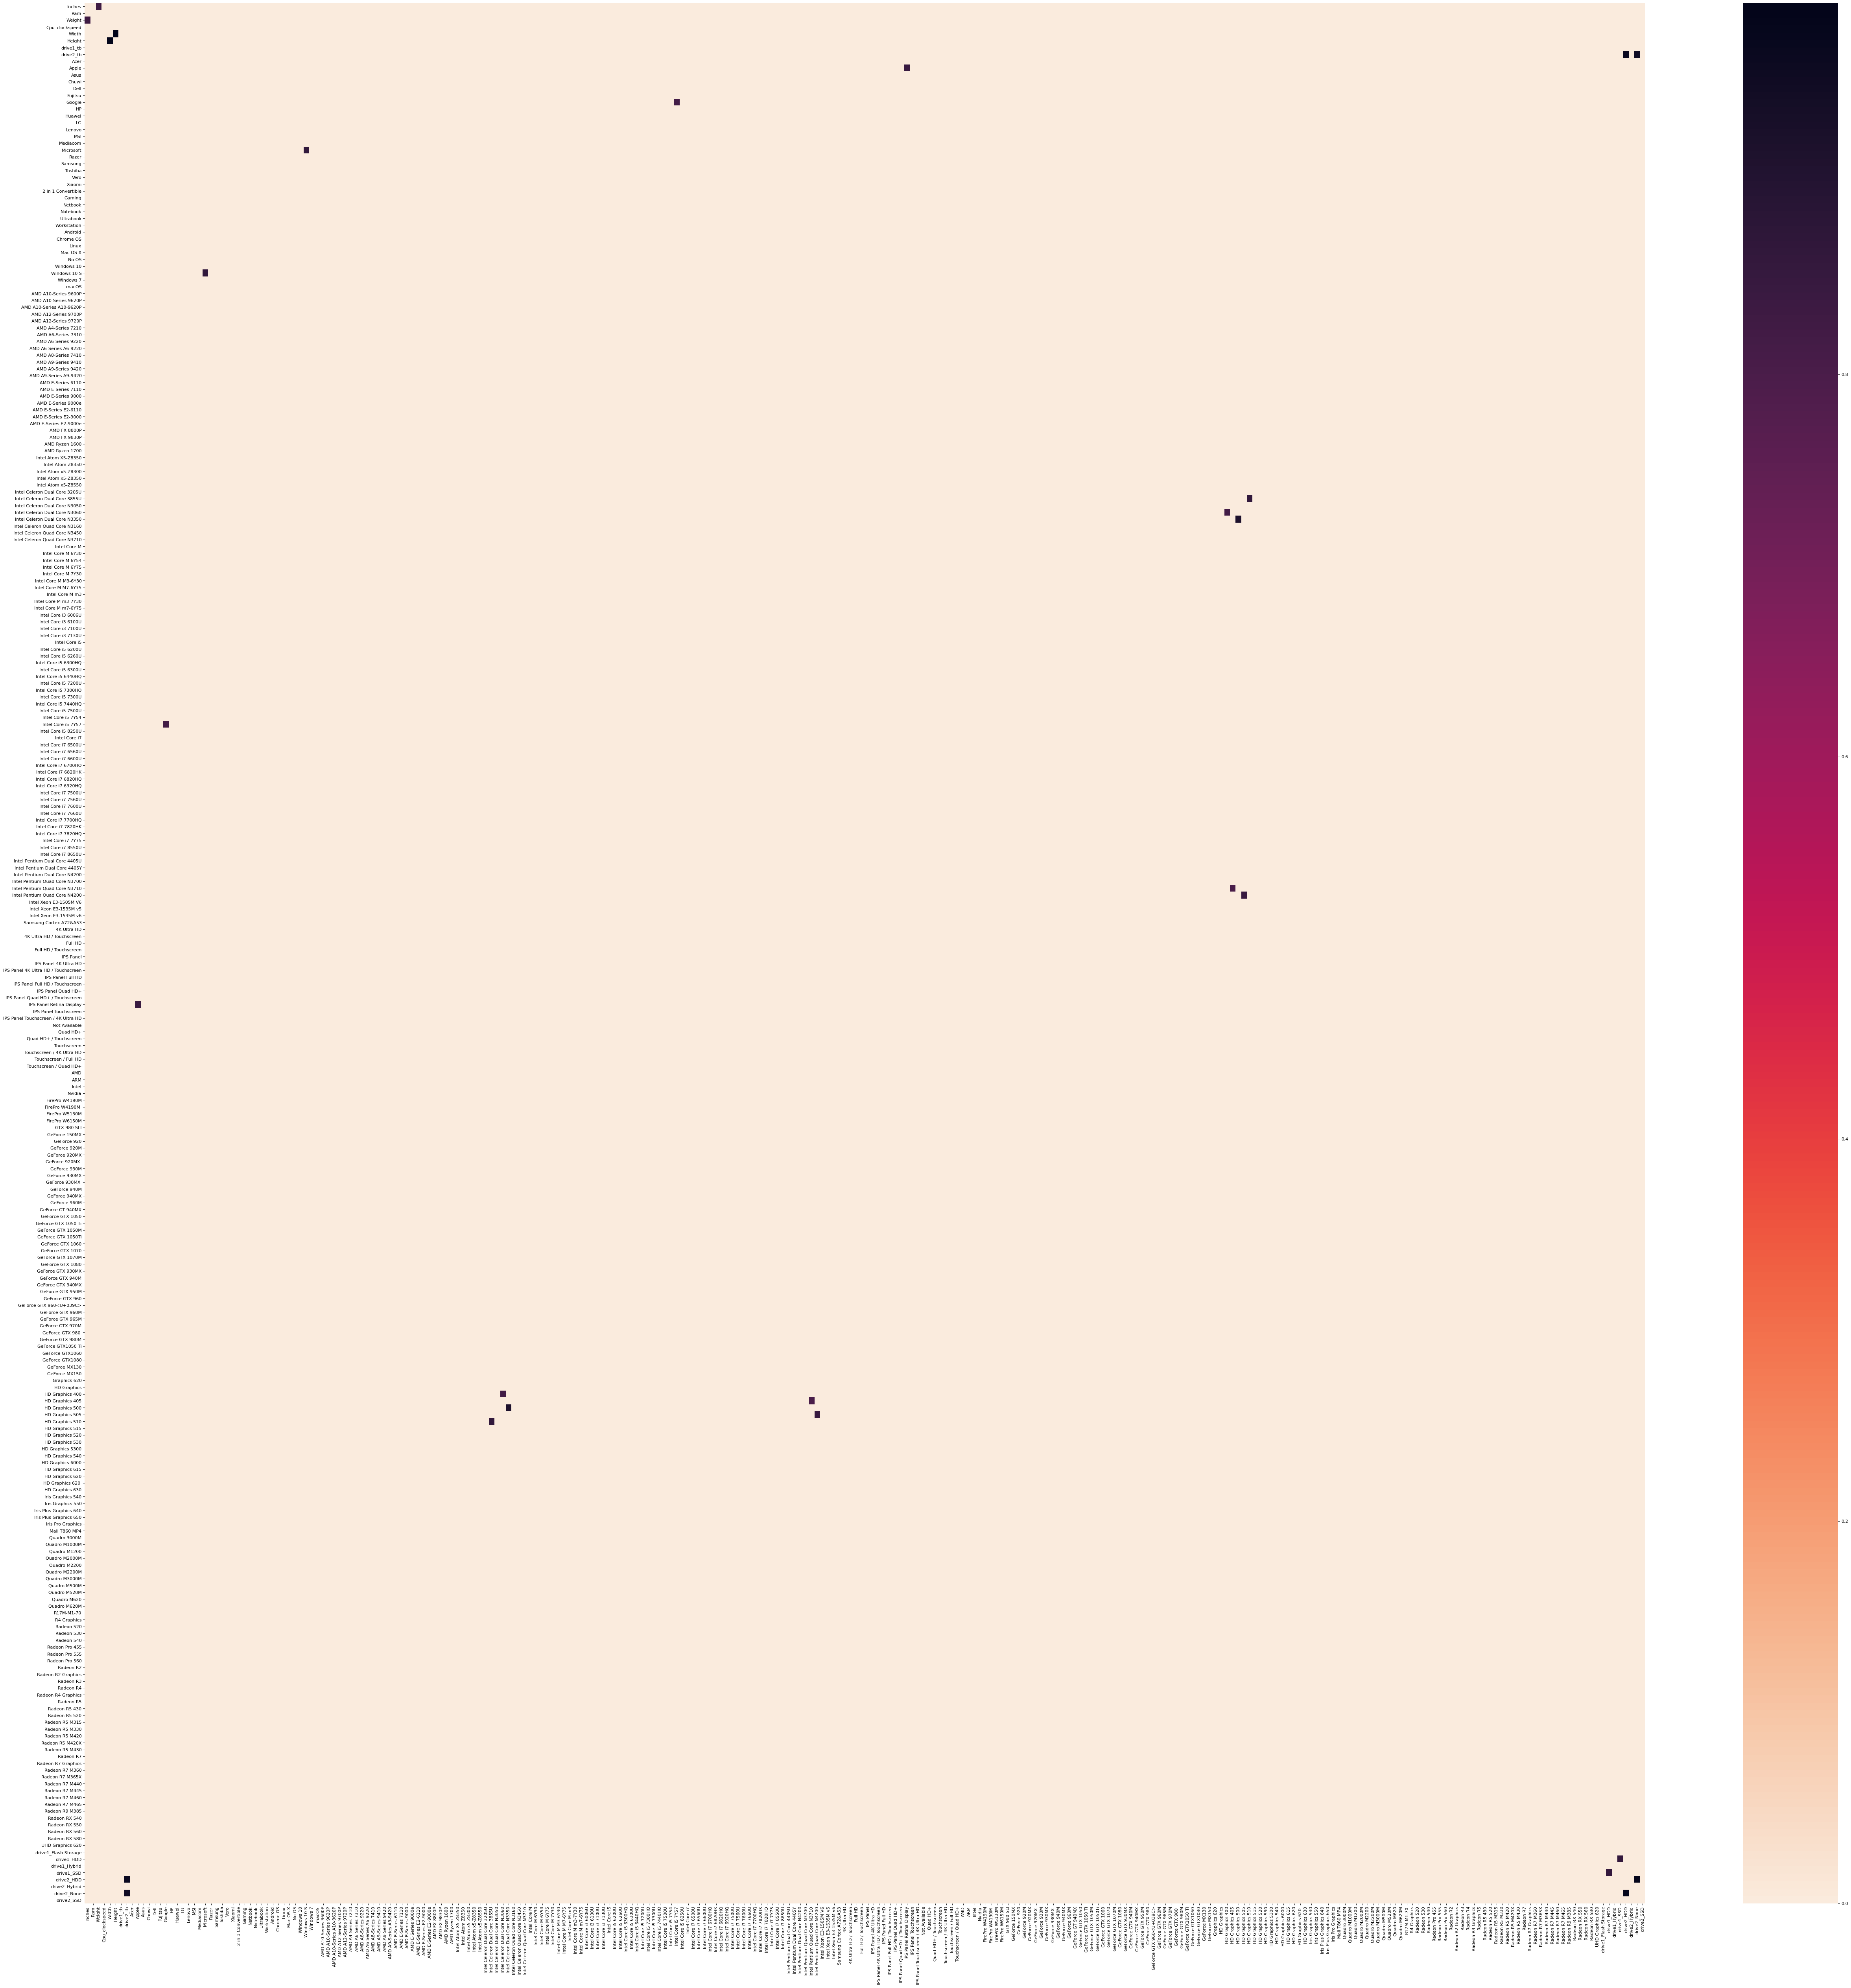

In [104]:
# Full Heatmap
figure(figsize=(80, 80), dpi=80)
cmap = sns.cm.rocket_r
sns.heatmap(corr_matrix[(corr_matrix > 0.8) & (corr_matrix != 1)].fillna(0), cmap=cmap)

In [105]:
# Drop column/category that have a highly correlation with each another (Above .8). 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.8)]
df_X = df_X.drop(columns = to_drop_corr)
# sns.heatmap(corr_matrix[(corr_matrix > 0.8) & (corr_matrix != 1)].fillna(0))

In [106]:
# # Drop column that have variance < 0.01
# to_drop_var = list(df.var()[df.var() < 0.01].index)
# df = df.drop(columns = to_drop_var)

# Tried to reduce the features by removing the columns that have low variance. However, the rmse score dropped instead of going up.

<AxesSubplot:>

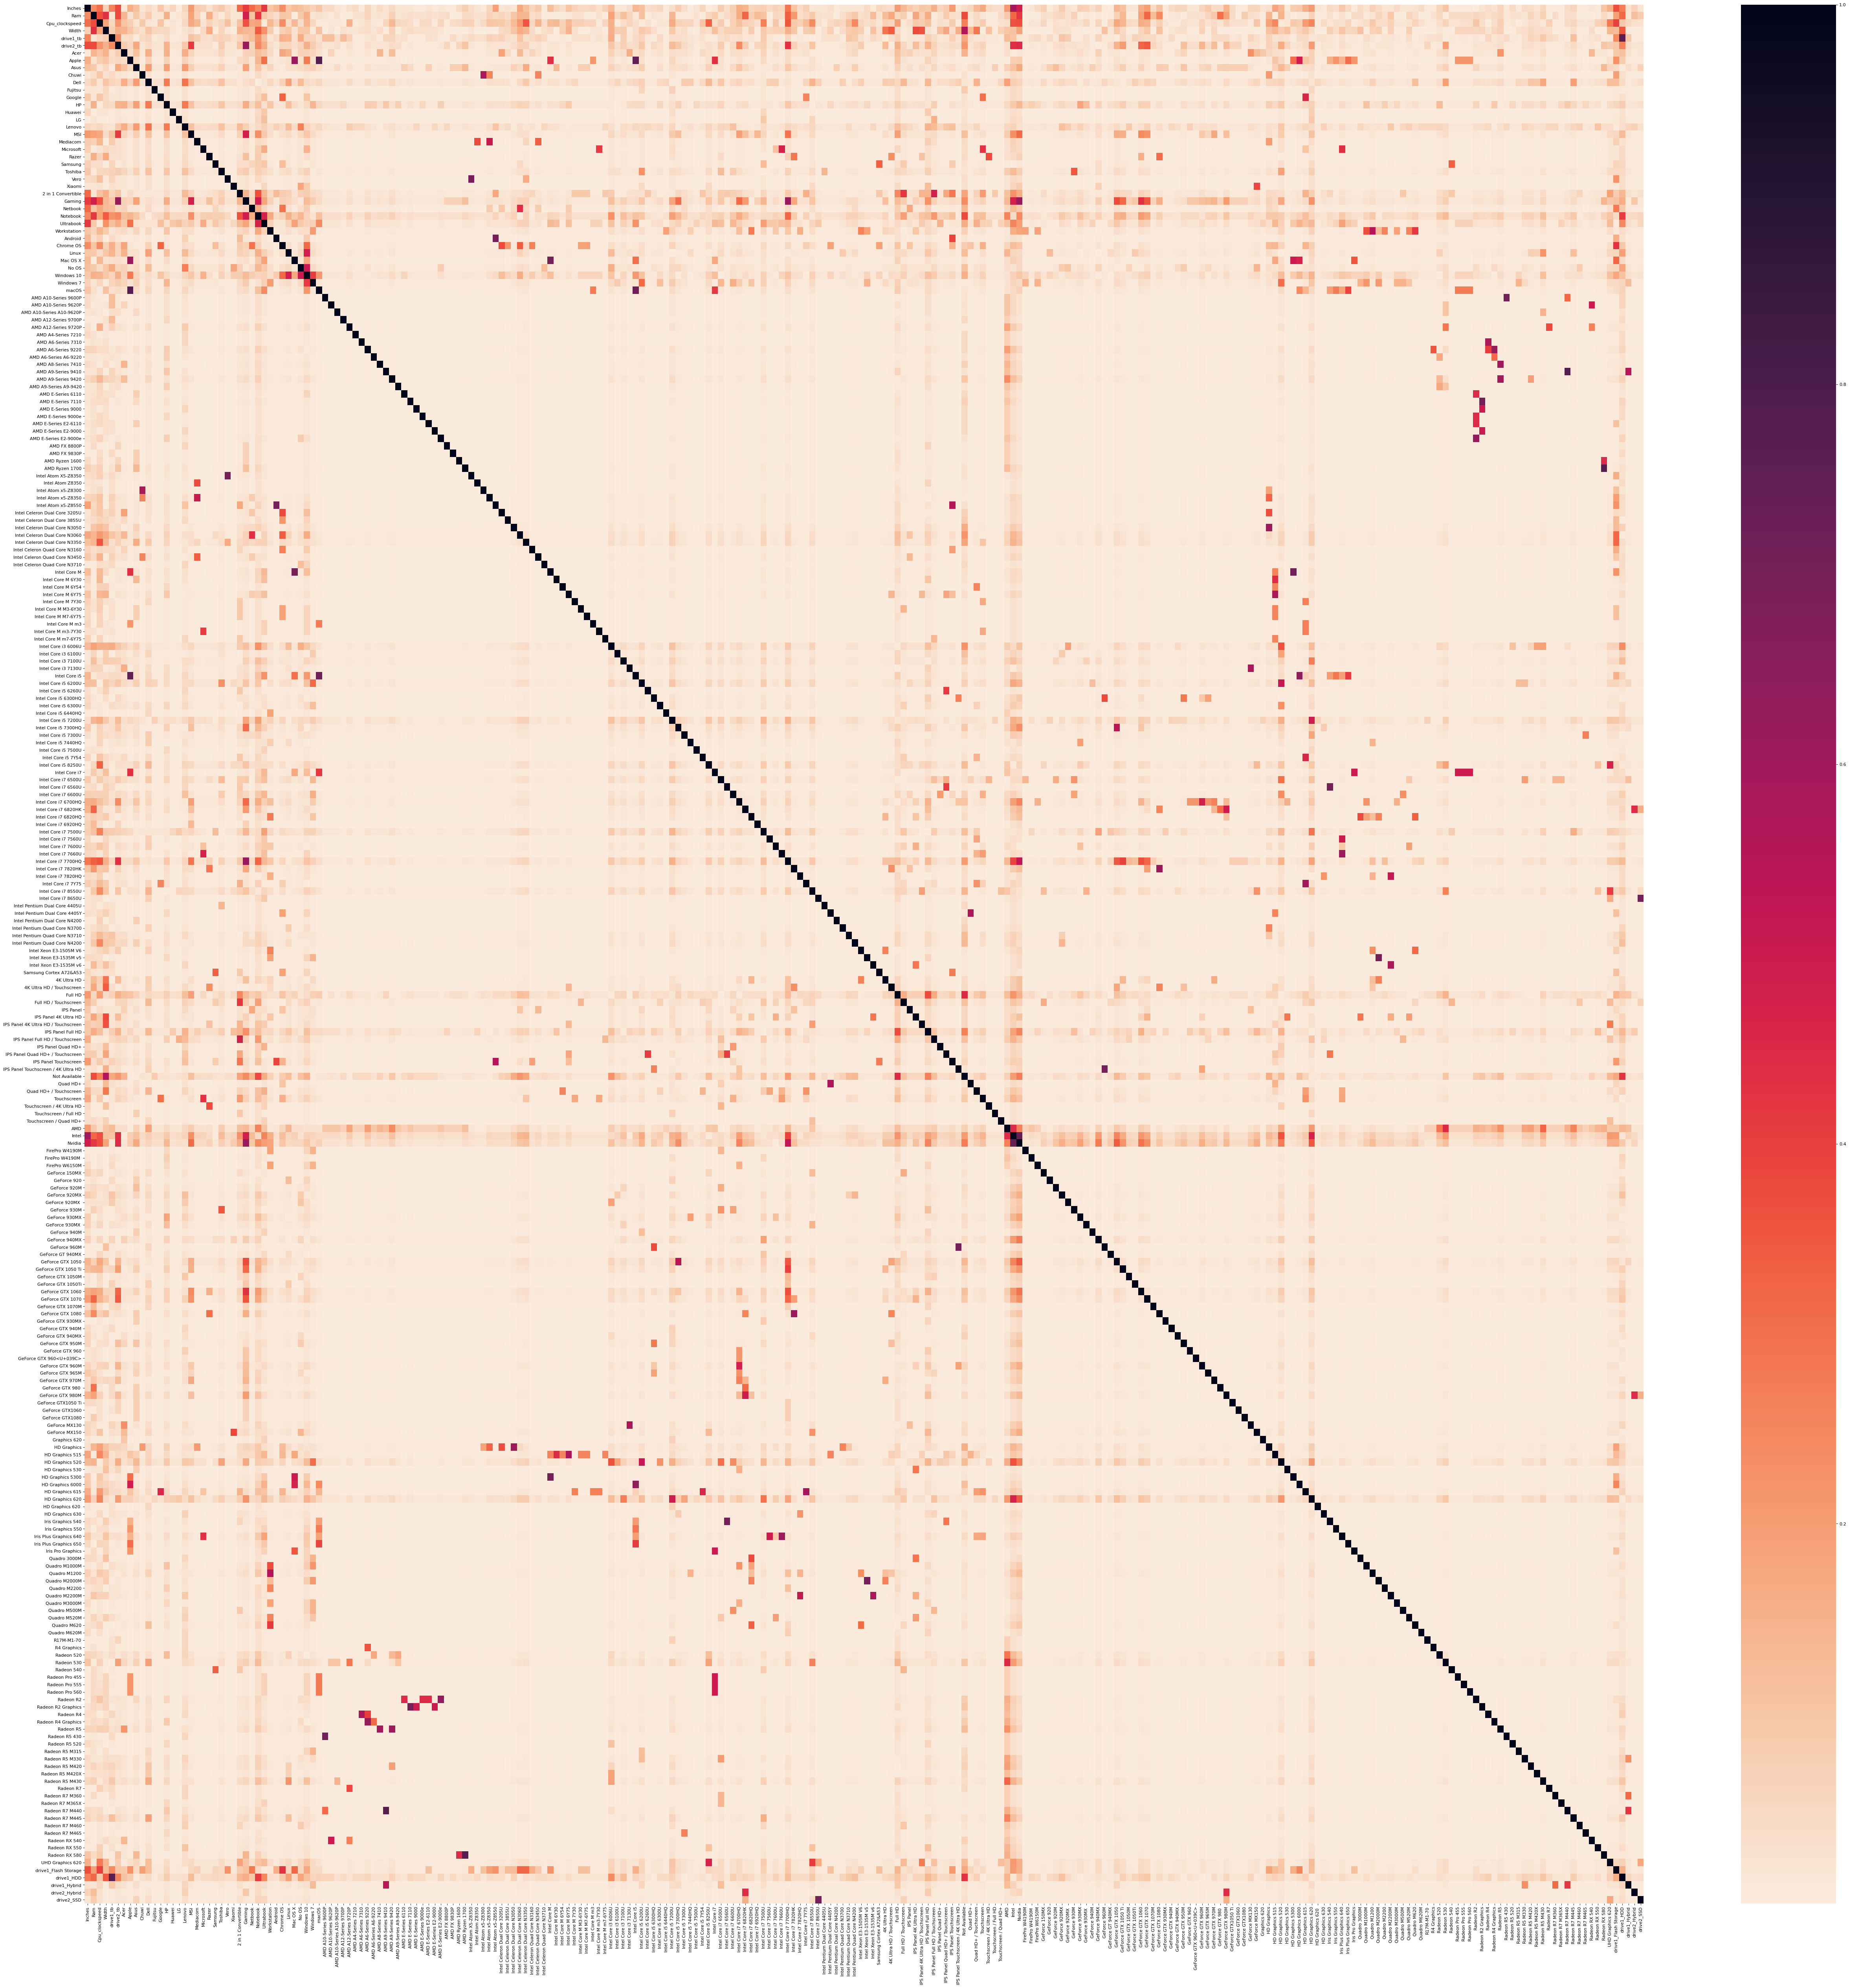

In [107]:
figure(figsize=(80, 80), dpi=80)
cmap = sns.cm.rocket_r
newCorrMatrix = df_X.corr().abs()
sns.heatmap(newCorrMatrix, cmap=cmap)

#### Some correlation such as Windows 10 S	- Microsoft are high but Windows 10 - Microsoft are not.
- This might be due to the poor adoptation of 10S from other manufacturer hence only Microsoft product are highly using it.
- I've googled for the reason - In fact this 10 S is only applicable for Microsoft Surface laptop

In [108]:
df_X.columns

Index(['Inches', 'Ram', 'Cpu_clockspeed', 'Width', 'drive1_tb', 'drive2_tb',
       'Acer', 'Apple', 'Asus', 'Chuwi',
       ...
       'Radeon R7 M465', 'Radeon RX 540', 'Radeon RX 550', 'Radeon RX 580',
       'UHD Graphics 620', 'drive1_Flash Storage', 'drive1_HDD',
       'drive1_Hybrid', 'drive2_Hybrid', 'drive2_SSD'],
      dtype='object', length=256)

### Train Test Split data for training and validation

In [109]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, test_size=0.2, random_state = 1)
print('Train X Size: ', train_X.shape)
print('Train y Size: ', train_y.shape)
print('Test X Size: ', test_X.shape)
print('Test y Size: ', test_y.shape)

Train X Size:  (1042, 256)
Train y Size:  (1042, 1)
Test X Size:  (261, 256)
Test y Size:  (261, 1)


### Apply scaler to all columns


In [110]:
scaler = MinMaxScaler()
scaler.fit(train_X)
scaled_X_train = scaler.transform(train_X)

# Using same train data scaler
scaled_X_test = scaler.transform(test_X)

### Build a model to predict company that release the product

In [111]:
# Test on 5 alpha parameter
model = RidgeCV(alphas = [0.01, 0.1, 1, 10, 100], store_cv_values=True)
model.fit(scaled_X_train, train_y)
y_pred = model.predict(scaled_X_test)

In [112]:
# Best alpha
model.alpha_

1.0

#### How well are the predictions?

In [113]:
# Model CV RMSE
np.sqrt(model.cv_values_.mean())

351.22145468475185

In [114]:
# Error Score using test and predicted data
print('MAE:', metrics.mean_absolute_error(test_y, y_pred))
print('MSE:', metrics.mean_squared_error(test_y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

MAE: 187.49766404728655
MSE: 78433.3339138939
RMSE: 280.0595185204279


In [115]:
# Test data result is better than validation data.

In [116]:
final = pd.concat([test_X, test_y], axis = 1).reset_index()
final = pd.concat([final, pd.DataFrame(y_pred)], axis = 1).reset_index().rename(columns = {0:'predicted_price'}).drop(columns = ['index', 'level_0'])
final = final.reset_index()

In [117]:
final[['Price_euros', 'predicted_price']].corr()
# Final prediction and actual price got 92-93% correlation

Price_euros  predicted_price
Price_euros             1.00             0.92
predicted_price         0.92             1.00

##### A good prediction should be along the black line

C:\Users\aaron\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Price')

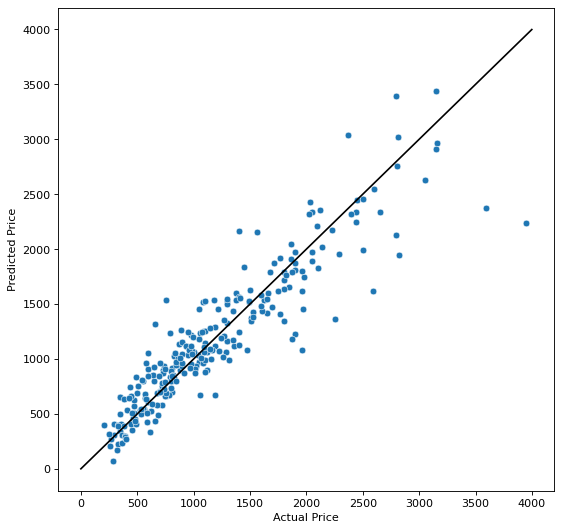

In [118]:
figure(figsize=(8, 8), dpi=80)

sns.scatterplot(data = final, x = 'Price_euros', y = 'predicted_price')
sns.lineplot(range(0,4000), range(0,4000), color = 'black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### For some reason Linear Regression cause the predicted value & scoring to be all over the place

In [119]:
lr = LinearRegression()
lr.fit(scaled_X_train, train_y)
y_pred = lr.predict(scaled_X_test)

In [120]:
# Error Score using test and predicted data
print('MAE:', metrics.mean_absolute_error(test_y, y_pred))
print('MSE:', metrics.mean_squared_error(test_y, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

MAE: 5046781360994.857
MSE: 1.0690860953957878e+27
RMSE: 32696882043947.062


In [121]:
final2 = pd.concat([test_X, test_y], axis = 1).reset_index()
final2 = pd.concat([final2, pd.DataFrame(y_pred)], axis = 1).reset_index().rename(columns = {0:'predicted_price'}).drop(columns = ['index', 'level_0'])
final2 = final2.reset_index()

In [122]:
final2[['Price_euros', 'predicted_price']].corr()

Price_euros  predicted_price
Price_euros             1.00            -0.04
predicted_price        -0.04             1.00

In [123]:
final2.head(50)

index  Inches   Ram  Cpu_clockspeed  Width  drive1_tb  drive2_tb  Acer  \
0       0   15.60  4.00            2.00   1366       0.49       0.00     1   
1       1   13.30  8.00            0.90   1920       0.50       0.00     0   
2       2   15.60 16.00            2.80   1920       0.25       0.00     0   
3       3   14.00  8.00            2.50   1920       0.25       0.00     0   
4       4   14.00  8.00            2.70   1920       0.50       0.00     0   
5       5   17.30  8.00            1.80   1920       1.00       0.00     0   
6       6   15.60  8.00            2.70   1920       0.25       0.00     0   
7       7   15.60  4.00            2.30   1366       0.25       0.00     0   
8       8   15.60  4.00            1.60   1366       0.49       0.00     1   
9       9   15.60  8.00            2.50   1920       0.50       0.00     0   
10     10   14.00  8.00            2.30   1920       0.25       0.00     0   
11     11   15.60  8.00            2.50   1920       1.00       0.00     0   
12     12   14.00  8.00            2.70   2560       0.25       0.00     0   
13     13   13.30  8.00            2.40   3200       0.25       0.00     0   
14     14   15.60  8.00            2.70   1920       1.00       0.00     0   
15     15   15.60 16.00            2.80   1920       0.12       1.00     0   
16     16   14.00  4.00            2.50   1366       0.49       0.00     0   
17     17   13.30  8.00            2.50   1920       0.25       0.00     0   
18     18   17.30  8.00            2.80   1920       1.00       0.00     0   
19     19   14.00  4.00            2.40   1366       0.25       0.00     0   
20     20   15.60  8.00            1.60   1920       0.25       0.00     0   
21     21   15.60  4.00            2.50   1920       1.00       0.00     0   
22     22   15.60 16.00            2.80   1920       0.50       0.00     0   
23     23   13.30  8.00            2.70   1920       0.25       0.00     0   
24     24   14.00  4.00            2.40   1920       0.12       0.00     0   
25     25   17.30 16.00            1.80   1920       0.25       2.00     0   
26     26   15.60  4.00            2.30   1366       0.12       0.00     0   
27     27   15.60  8.00            2.50   1366       2.00       0.00     0   
28     28   13.30  8.00            2.50   1920       0.25       0.00     0   
29     29   15.60 12.00            2.50   1920       0.12       1.00     1   
30     30   17.30 16.00            2.80   3840       0.50       1.00     0   
31     31   15.60  4.00            2.50   1366       0.49       0.00     1   
32     32   15.60  8.00            2.50   1920       0.25       0.00     0   
33     33   13.30  8.00            2.50   1920       0.25       0.00     0   
34     34   13.30 16.00            2.70   3840       0.50       0.00     0   
35     35   15.60  4.00            2.00   1366       0.12       0.00     0   
36     36   15.60  8.00            2.70   1366       1.00       0.00     0   
37     37   15.60  4.00            2.50   1920       1.00       0.00     0   
38     38   15.60  4.00            2.20   1366       0.12       0.00     0   
39     39   14.00  8.00            2.30   1920       0.25       0.00     0   
40     40   13.30  8.00            2.50   1920       0.25       0.00     0   
41     41   15.60  4.00            2.00   1920       0.49       0.00     0   
42     42   13.30  4.00            2.40   1920       0.12       0.00     0   
43     43   14.00  4.00            2.30   1366       0.49       0.00     0   
44     44   13.30  8.00            1.60   1920       0.25       0.00     0   
45     45   15.60  4.00            2.50   1366       0.49       0.00     0   
46     46   13.30  4.00            2.50   1920       0.12       0.00     0   
47     47   13.30 16.00            2.50   3200       0.50       0.00     0   
48     48   11.30  8.00            1.20   1920       0.25       0.00     0   
49     49   13.30 16.00            1.30   3200       0.50       0.00     0   

    Apple  Asus  Chuwi  D

Text(0, 0.5, 'Predicted Price')

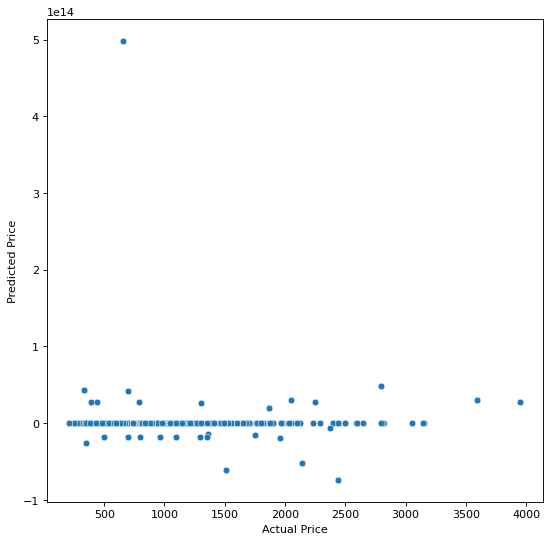

In [124]:
figure(figsize=(8, 8), dpi=80)

sns.scatterplot(data = final2, x = 'Price_euros', y = 'predicted_price')
# sns.lineplot(range(0,4000), range(0,4000), color = 'black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

### Decision Tree Regressor

In [125]:
import sklearn.model_selection
grid = sklearn.model_selection.GridSearchCV(
    DecisionTreeRegressor(random_state=1),
    param_grid={'max_depth': range(1,10)},
    cv=sklearn.model_selection.LeaveOneOut(),
    scoring='neg_root_mean_squared_error'
)
grid.fit(scaled_X_train, train_y)

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': range(1, 10)},
             scoring='neg_root_mean_squared_error')

In [126]:
pred_y = grid.predict(scaled_X_test)

In [127]:
# Error Score using test and predicted data
print('MAE:', metrics.mean_absolute_error(test_y, pred_y))
print('MSE:', metrics.mean_squared_error(test_y, pred_y))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, pred_y)))

MAE: 218.4227219585971
MSE: 117960.28324864077
RMSE: 343.4534659144391


In [128]:
final3 = pd.concat([test_X, test_y], axis = 1).reset_index()
final3 = pd.concat([final3, pd.DataFrame(pred_y)], axis = 1).reset_index().rename(columns = {0:'predicted_price'}).drop(columns = ['index', 'level_0'])
final3 = final3.reset_index()

In [129]:
final3[['Price_euros', 'predicted_price']].corr()

Price_euros  predicted_price
Price_euros             1.00             0.88
predicted_price         0.88             1.00

C:\Users\aaron\myenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Price')

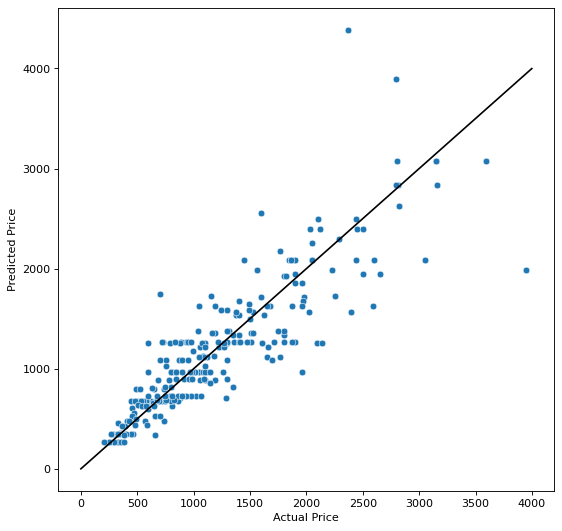

In [130]:
figure(figsize=(8, 8), dpi=80)

sns.scatterplot(data = final3, x = 'Price_euros', y = 'predicted_price')
sns.lineplot(range(0,4000), range(0,4000), color = 'black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

In [133]:
df[df['Price_euros']> 3500]

Inches   Ram  Weight  Price_euros  Cpu_clockspeed  Width  Height  \
196    17.30 32.00    3.49      6099.00            2.90   3840    2160   
238    17.30 32.00    4.70      3890.00            2.90   1920    1080   
610    15.60 32.00    2.50      4899.00            3.10   3840    2160   
723    17.30 32.00    4.36      3659.40            2.80   3840    2160   
749    17.30 16.00    3.00      4389.00            2.90   1920    1080   
780    17.30 32.00    4.42      3588.80            2.80   1920    1080   
830    17.30 32.00    3.49      5499.00            2.90   3840    2160   
1066   17.30 64.00    3.58      3975.00            2.70   1920    1080   
1136   17.30  8.00    3.00      3949.40            2.60   1920    1080   

      drive1_tb  drive2_tb  Acer  Apple  Asus  Chuwi  Dell  Fujitsu  Google  \
196        1.00       0.00     0      0     0      0     0        0       0   
238        0.50       1.00     0      0     1      0     0        0       0   
610        1.00       0.00     0      0     0      0     0        0       0   
723        1.00       1.00     0      0     0      0     1        0       0   
749        0.25       0.00     0      0     0      0     0        0       0   
780        1.00       1.00     0      0     0      0     1        0       0   
830        0.50       0.00     0      0     0      0     0        0       0   
1066       1.00       0.00     0      0     1      0     0        0       0   
1136       0.25       0.00     0      0     0      0     0        0       0   

      HP  Huawei  LG  Lenovo  MSI  Mediacom  Microsoft  Razer  Samsung  \
196    0       0   0       0    0         0          0      1        0   
238    0       0   0       0    0         0          0      0        0   
610    0       0   0       1    0         0          0      0        0   
723    0       0   0       0    0         0          0      0        0   
749    1       0   0       0    0         0          0      0        0   
780    0       0   0       0    0         0          0      0        0   
830    0       0   0       0    0         0          0      1        0   
1066   0       0   0       0    0         0          0      0        0   
1136   1       0   0       0    0         0          0      0        0   

      Toshiba  Vero  Xiaomi  2 in 1 Convertible  Gaming  Netbook  Notebook  \
196         0     0       0                   0       1        0         0   
238         0     0       0                   0       1        0         0   
610         0     0       0                   0       0        0         1   
723         0     0       0                   0       1        0         0   
749         0     0       0                   0       0        0         0   
780         0     0       0                   0       1        0         0   
830         0     0       0                   0       1        0         0   
1066        0     0       0                   0       1        0         0   
1136        0     0       0                   0       0        0         0   

      Ultrabook  Workstation  Android  Chrome OS  Linux  Mac OS X  No OS  \
196           0            0        0          0      0         0      0   
238           0            0        0          0      0         0      0   
610           0            0        0          0      0         0      0   
723           0            0        0          0      0         0      0   
749           0            1        0          0      0         0      0   
780           0            0        0          0      0         0      0   
830           0            0        0          0      0         0      0   
1066          0            0        0          0      0         0      0   
1136          0            1        0          0      0         0      0   

      Windows 10  Windows 10 S  Windows 7  macOS  AMD A10-Series 9600P  \
196            1             0          0      0                     0   
238            1             0          0  